## Recency, Frequency, Monetary Analysis

In [1]:
### Importing the necessary Libaries

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor,XGBRFClassifier
from matplotlib import pyplot as plt

In [2]:
## Read our data file

rfm_data =pd.read_csv(r'C:\Users\IamFavoured\Desktop\IKEBUKWU\Database\Clv\CDNOW_master.txt',sep='\s+',names=["customer_id","date","quantity","price"])

### Data Cleaning

In [3]:
## The top 5 rows of our dataframe

rfm_data.head()

,customer_id,date,quantity,price
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [4]:
## Total number of rows and columns

rfm_data.shape

(69659, 4)

In [5]:
### Number of null values in each column

rfm_data.isnull().sum()

customer_id    0
date           0
quantity       0
price          0
dtype: int64

In [6]:
## Information on our dataframe

rfm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [7]:
### Converting our date column from an integer type to a datetime data type

rfm_data['date']=rfm_data['date'].astype(str)
rfm_data['date']=pd.to_datetime(rfm_data['date'])

In [8]:
rfm_data.head()   ## First 5 rows

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [9]:
## Data Frame information

rfm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


### Data Exploration/Mining

In [10]:
## The first time a customer purchased

customer_first_purchase =rfm_data.groupby('customer_id').first()
customer_first_purchase.head()

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33


In [11]:
## The last time a customer purchased

rfm_data.groupby('customer_id').last().head()

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,5,77.00
3,1998-05-28,1,16.99
4,1997-12-12,2,26.48
5,1998-01-03,3,37.47


In [12]:
### Total Revenue in each month

rfm_data.set_index('date').resample('M').sum()[['price']].head()

,price
date,
1997-01-31,299060.17
1997-02-28,379590.03
1997-03-31,393155.27
1997-04-30,142824.49
1997-05-31,107933.30


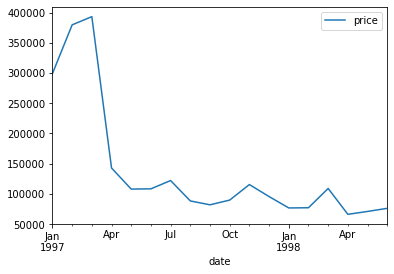

In [13]:
### Plot of the total Revenue in each month

rfm_data.set_index('date').resample('M').sum()[['price']].plot();

In [14]:
### There is a plunge in revenue from febuary to May
### We need to understand why
### That is where Diagnostic analysis comes into play
### Diagnostic analysis involves drilling into internal as well as external sources of anomalies to detect key drivers in bussiness outcomes

#### Subset of DataFrame

In [15]:
## We are going to get a subset of our data frame to carryout RFM analysis

ids =rfm_data['customer_id'].unique()
ids

array([    1,     2,     3, ..., 23568, 23569, 23570], dtype=int64)

In [16]:
ids_selected = ids[0:10]
ids_selected

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [17]:
subset_df = rfm_data[rfm_data['customer_id'].isin(ids_selected)].set_index('customer_id')
subset_df.head()

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
2,1997-01-12,5,77.00
3,1997-01-02,2,20.76
3,1997-03-30,2,20.76


### Feature Engineering

In [18]:
## We are going to Split our dataset inorder for us to get our features(independent variables)
## And our targets (dependent Variables)
## After Splittling, we will carry out feature engr on the available fields to get our RFM features
## The aim of this project is to predict the revenue each customer will generate
## As well as the probability he is going to spend within that time window

max_date = subset_df['date'].max()    ## Max date in the subset df
max_date

Timestamp('1998-06-08 00:00:00')

In [19]:
cutoff =max_date-pd.to_timedelta(90,unit='D')
cutoff

Timestamp('1998-03-10 00:00:00')

In [20]:
## Seperating the dataframe using a 90 days window

features_df =subset_df[subset_df['date']<= cutoff]
features_df.head()

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
2,1997-01-12,5,77.00
3,1997-01-02,2,20.76
3,1997-03-30,2,20.76


In [21]:
target_df =subset_df[subset_df['date']> cutoff]
target_df

,date,quantity,price
customer_id,,,
3,1998-05-28,1,16.99
7,1998-03-22,9,138.50
8,1998-03-29,2,24.46
9,1998-06-08,2,41.98


### Target

In [22]:
target_df = target_df.drop(columns=['quantity','date']).rename(columns={'price':'spend_90_total'}).assign(spend_90_flag=1)
target_df

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
7,138.50,1
8,24.46,1
9,41.98,1


### Features

#### Recency Features

In [23]:
## Recency - this accounts for the number of days that has passed when a customer successfully made his last purchase
## Recency is measured in days

recency_features_df=features_df[['date']].groupby('customer_id').apply(lambda x: (x.date.max() - max_date)/pd.to_timedelta(1,"day")).to_frame().set_axis(['recency'],axis=1)
recency_features_df

,recency
customer_id,
1,-523.0
2,-512.0
3,-195.0
4,-178.0
5,-156.0
6,-523.0
7,-240.0
8,-165.0
9,-391.0


#### Frequency features

In [24]:
## How many times has a customer made a successful purchase

frequency_features_df = features_df.groupby('customer_id').count()['quantity'].to_frame().set_axis(['frequency'],axis=1)
frequency_features_df

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
6,1
7,2
8,7
9,2


In [25]:
## Aggregate price of each customer's cumulative order

price_features_df = features_df.groupby('customer_id')[['price']].agg(['sum','mean']).set_axis(['price_sum','price_mean'],axis=1)
price_features_df

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
6,20.99,20.990000
7,126.17,63.085000
8,173.20,24.742857
9,53.87,26.935000


### Combine Features

In [26]:
combined_df = pd.concat([recency_features_df,frequency_features_df,price_features_df],axis=1).merge(target_df,left_index=True,right_index=True,how='left').fillna(0,axis=1)
combined_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-523.0,1.0,11.77,11.770000,0.00,0.0
2,-512.0,2.0,89.00,44.500000,0.00,0.0
3,-195.0,5.0,139.47,27.894000,16.99,1.0
4,-178.0,4.0,100.50,25.125000,0.00,0.0
5,-156.0,11.0,385.61,35.055455,0.00,0.0
6,-523.0,1.0,20.99,20.990000,0.00,0.0
7,-240.0,2.0,126.17,63.085000,138.50,1.0
8,-165.0,7.0,173.20,24.742857,24.46,1.0
9,-391.0,2.0,53.87,26.935000,41.98,1.0


### Machine Learning

In [27]:
## Independent Variable

X =combined_df[['recency','frequency','price_sum','price_mean']]
X

,recency,frequency,price_sum,price_mean
customer_id,,,,
1,-523.0,1.0,11.77,11.770000
2,-512.0,2.0,89.00,44.500000
3,-195.0,5.0,139.47,27.894000
4,-178.0,4.0,100.50,25.125000
5,-156.0,11.0,385.61,35.055455
6,-523.0,1.0,20.99,20.990000
7,-240.0,2.0,126.17,63.085000
8,-165.0,7.0,173.20,24.742857
9,-391.0,2.0,53.87,26.935000


### Regression model

In [29]:
## Dependent variable for regression problem

y_spend = combined_df['spend_90_total']
y_spend

customer_id
1       0.00
2       0.00
3      16.99
4       0.00
5       0.00
6       0.00
7     138.50
8      24.46
9      41.98
10      0.00
Name: spend_90_total, dtype: float64

In [30]:
## Get the model

model_reg = XGBRegressor(objective="reg:squarederror",random_state=123)

In [31]:
## Fit/train the model

model_reg.fit(X,y_spend)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

In [32]:
pred_spend=model_reg.predict(X)

#### Feature Importance -regression

In [33]:
## Lets ascertain how the individual features affect the predicted outcome

model_reg.feature_importances_

array([0.05542977, 0.06038005, 0.        , 0.8841902 ], dtype=float32)

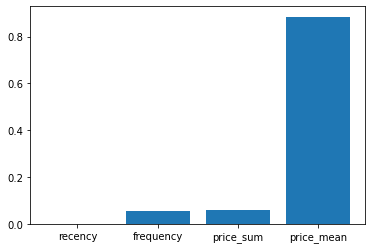

In [34]:
plt.bar(height=np.sort(model_reg.feature_importances_), x=['recency','frequency','price_sum','price_mean']);

### Classification model

In [37]:
## Dependent variable for classification problem

y_prob= combined_df.spend_90_flag
y_prob

customer_id
1     0.0
2     0.0
3     1.0
4     0.0
5     0.0
6     0.0
7     1.0
8     1.0
9     1.0
10    0.0
Name: spend_90_flag, dtype: float64

In [38]:
## Get the model

model_clf = LogisticRegression()

In [39]:
## Fit/train the model

model_clf.fit(X,y_prob)

LogisticRegression()

In [40]:
## Score: performance metric for the model

model_clf.score(X,y_prob)

0.8

In [41]:
pred_prob=model_clf.predict(X)
pred_prob

array([0., 0., 1., 1., 0., 0., 1., 1., 0., 0.])

In [41]:
## Probability of each outcome in the classification problem

prob=model_clf.predict_proba(X)
prob

array([[0.94865133, 0.05134867],
       [0.87655064, 0.12344936],
       [0.29933246, 0.70066754],
       [0.17983126, 0.82016874],
       [0.89292634, 0.10707366],
       [0.92277207, 0.07722793],
       [0.09311795, 0.90688205],
       [0.31838942, 0.68161058],
       [0.67617998, 0.32382002],
       [0.79219137, 0.20780863]])

#### Feature Importance

In [43]:
model_clf.coef_

array([[ 0.01382727,  0.22240253, -0.02169077,  0.06895553]])

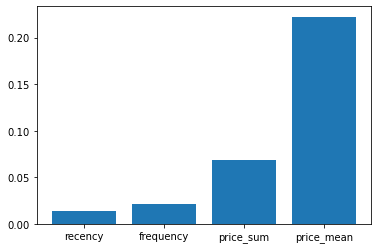

In [70]:
plt.bar(height=np.sort(np.abs(model_clf.coef_.ravel())), x=['recency','frequency','price_sum','price_mean']);

### Dataframe

In [42]:
combined_df['pred_spend']=pred_spend.tolist()
combined_df['prob_not_spend']=prob[:,0]
combined_df['prob_spend']=prob[:,1]

In [43]:
combined_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,pred_spend,prob_not_spend,prob_spend
customer_id,,,,,,,,,
1,-523.0,1.0,11.77,11.770000,0.00,0.0,0.000395,0.948651,0.051349
2,-512.0,2.0,89.00,44.500000,0.00,0.0,0.000395,0.876551,0.123449
3,-195.0,5.0,139.47,27.894000,16.99,1.0,16.990019,0.299332,0.700668
4,-178.0,4.0,100.50,25.125000,0.00,0.0,0.001159,0.179831,0.820169
5,-156.0,11.0,385.61,35.055455,0.00,0.0,0.000472,0.892926,0.107074
6,-523.0,1.0,20.99,20.990000,0.00,0.0,0.000395,0.922772,0.077228
7,-240.0,2.0,126.17,63.085000,138.50,1.0,138.498749,0.093118,0.906882
8,-165.0,7.0,173.20,24.742857,24.46,1.0,24.459238,0.318389,0.681611
9,-391.0,2.0,53.87,26.935000,41.98,1.0,41.978779,0.676180,0.323820
